In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%store -r final_draftDB

In [3]:
final_draftDB.head()

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer
0,1,Chicago Blackhawks,Patrick Kane,RW,18.0,177.80,178.0,43.0,58.0,101.0,11.27172,29.52000,40.79172,18.24828,1.0
1,2,Philadelphia Flyers,James van Riemsdyk,LW,18.0,190.50,200.0,32.0,30.0,62.0,3.78102,12.60094,16.38196,8.81992,1.0
2,3,Phoenix Coyotes,Kyle Turris,C,18.0,185.42,185.0,57.0,53.0,110.0,8.26560,14.95680,23.22240,6.69120,1.0
3,4,Los Angeles Kings,Thomas Hickey,D,18.0,180.34,184.0,69.0,68.0,137.0,4.74042,8.55588,13.29630,3.81546,1.0
4,5,Washington Capitals,Karl Alzner,D,18.0,190.50,206.0,70.0,63.0,133.0,3.93108,8.67150,12.60258,4.74042,1.0


### Select Overall as target variable (rather than 200GP)

In [4]:
x_db = final_draftDB.drop(['Overall', 'Team', 'Player', 'NHLer'], axis=1)

y_db = final_draftDB['Overall']

## Train Test Split

In [5]:
X_train = x_db.loc[0:1132]
X_test = x_db.loc[1133:1512]
y_train = y_db.loc[:1132]
y_test = y_db.loc[1133:1512]

## Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

### One hot encoder

In [123]:
ohe = OneHotEncoder(sparse=False)

### PCA for categorical variable

In [124]:
# Select number of principle components
pca = PCA(n_components=1)

### Select Kbest for numeric variables

In [125]:
# Instantiate SelectKBest Variable
selection = SelectKBest(k=6)

### Instantiating Standard Scaler

In [126]:
scaler=StandardScaler()

### Instantiating Model

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

In [128]:
Gb_clf = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=250)

### Set up Pipeline

In [129]:
# define individual transformers in a pipeline

categorical_preprocessing = Pipeline([('ohe', OneHotEncoder(sparse=False)),
                                     ('PCA', pca)])

numerical_preprocessing = Pipeline([('scale', StandardScaler()),
                                   ('selectK_best', selection)])

In [130]:
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['Pos']),
    ('numerical_preprocessing', numerical_preprocessing, ['Age', 'Height', 'Weight',
                                                          'D-1_GP', 'D0_GP',
                                                          'Total GP', 'D-1_NHLe',
                                                          'D0_NHLe', 'NHLe Total',
                                                          'NHLe Progression'
                                                         ])
])
    
preprocess

ColumnTransformer(transformers=[('categorical_preprocessing',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(sparse=False)),
                                                 ('PCA', PCA(n_components=1))]),
                                 ['Pos']),
                                ('numerical_preprocessing',
                                 Pipeline(steps=[('scale', StandardScaler()),
                                                 ('selectK_best',
                                                  SelectKBest(k=6))]),
                                 ['Age', 'Height', 'Weight', 'D-1_GP', 'D0_GP',
                                  'Total GP', 'D-1_NHLe', 'D0_NHLe',
                                  'NHLe Total', 'NHLe Progression'])])

In [131]:
# create the final pipeline with preprocessing steps and 
# the final classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('best_model', Gb_clf)
])

pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False)),
                                                                  ('PCA',
                                                                   PCA(n_components=1))]),
                                                  ['Pos']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('selectK_best',
                                                                   SelectKBest(k=6))]),
                                                  ['Age', 'Height', 'Weight',
                                                   'D-1_GP', 'D0_GP',
                                                   'Total GP', 'D-1_NHLe',
                                                   'D0_NHLe', 'NHLe Total',
                                                   'NHLe Progression'])])),
                ('best_model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=5,
                                           n_estimators=250))])

In [132]:
# Call the pipeline on the training data

xgb_model = pipeline.fit(X_train, y_train)

In [133]:
xgb_model.score(X_test, y_test)

0.3200609154254336

In [134]:
feat_names = pipeline.steps[0][1].get_feature_names_out()
feat_import = pipeline.steps[1][1].feature_importances_

<AxesSubplot: >

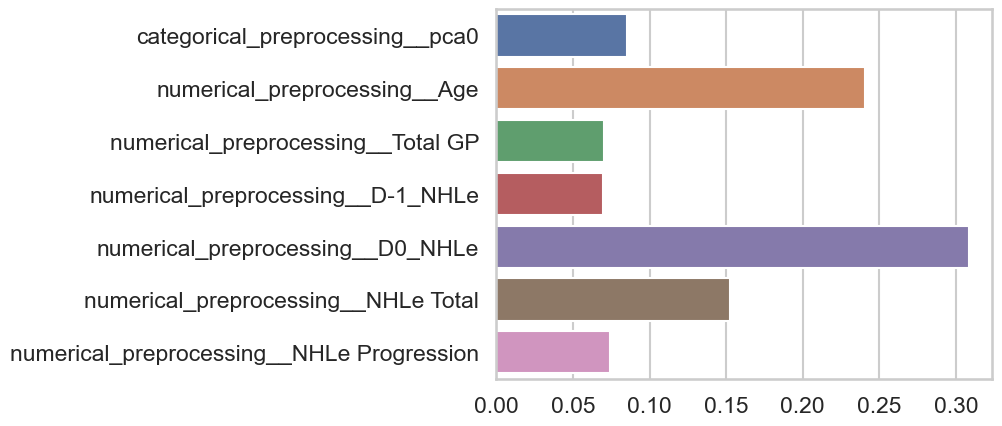

In [135]:
sns.set_theme(style='whitegrid', context='talk')

sns.set_color_codes('pastel')
sns.barplot(x=feat_import, y=feat_names)

In [136]:
arr = xgb_model.predict(X_test)

### Using GridSearch for Parameter tuning

In [118]:
from sklearn.model_selection import GridSearchCV

In [119]:
param_grid = [
    {
        'best_model__learning_rate': [0.001, 0.01, 0.1, 1.0],
        'best_model__n_estimators': [10, 100, 250],
        'best_model__max_depth': [3, 4, 5]
    }
]

In [120]:
gridSearch = GridSearchCV(xgb_model, param_grid=param_grid, n_jobs=-1, verbose=3)
gridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(sparse=False)),
                                                                                         ('PCA',
                                                                                          PCA(n_components=1))]),
                                                                         ['Pos']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('selectK_best',
                                                                                          SelectKBest(k=6))]),
                                                                         ['Age',
                                                                          'Height',
                                                                          'Weight',
                                                                          'D-1_GP',
                                                                          'D0_GP',
                                                                          'Total '
                                                                          'GP',
                                                                          'D-1_NHLe',
                                                                          'D0_NHLe',
                                                                          'NHLe '
                                                                          'Total',
                                                                          'NHLe '
                                                                          'Progression'])])),
                                       ('best_model',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid=[{'best_model__learning_rate': [0.001, 0.01, 0.1, 1.0],
                          'best_model__max_depth': [3, 4, 5],
                          'best_model__n_estimators': [10, 100, 250]}],
             verbose=3)

In [121]:
print('Final score is: ', gridSearch.score(X_test, y_test))

Final score is:  0.32002169418660653


In [122]:
gridSearch.best_params_

{'best_model__learning_rate': 0.01,
 'best_model__max_depth': 5,
 'best_model__n_estimators': 250}

### Creating the mock draft

In [137]:
overall_reg = []

for i in arr:
    overall_reg.append(i)

In [138]:
overall = pd.DataFrame(overall_reg)

In [139]:
X_test['Overall_reg'] = overall.iloc[:,0].values

/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_92576/2814795837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Overall_reg'] = overall.iloc[:,0].values


In [140]:
X_test['Player'] = final_draftDB.loc[1133:1512]['Player']
X_test['Overall'] = final_draftDB.loc[1133:1512]['Overall']

/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_92576/811153666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Player'] = final_draftDB.loc[1133:1512]['Player']
/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_92576/811153666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Overall'] = final_draftDB.loc[1133:1512]['Overall']


In [143]:
X_test.loc[1133:1322].sort_values('Overall_reg', ascending=True).head(60)

,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,Overall,Player,Overall_reg
1137,C,18.0,198.12,192.0,36.0,48.0,84.0,2.67648,29.23956,31.91604,26.56308,5,Elias Lindholm,18.667664
1202,LW,18.0,170.18,156.0,60.0,59.0,119.0,13.48490,18.52708,32.01198,5.04218,76,Taylor Cammarata,23.450571
1133,C,18.0,198.12,182.0,58.0,44.0,102.0,12.41644,15.75220,28.16864,3.33576,1,Nathan MacKinnon,24.970926
1151,LW,18.0,198.12,205.0,68.0,68.0,136.0,12.87072,15.11424,27.98496,2.24352,19,Kerby Rychel,26.157036
1138,C,18.0,198.12,187.0,62.0,58.0,120.0,14.87808,15.82272,30.70080,0.94464,6,Sean Monahan,26.406723
1163,D,18.0,187.96,205.0,55.0,53.0,108.0,4.22136,9.73258,13.95394,5.51122,31,Ian McCoshen,27.140128
1184,LW,18.0,180.34,163.0,40.0,45.0,85.0,9.18810,24.22854,33.41664,15.04044,55,Artturi Lehkonen,27.447226
1134,C,18.0,198.12,209.0,32.0,53.0,85.0,18.08100,32.90742,50.98842,14.82642,2,Aleksander Barkov,27.546682
1156,LW,18.0,177.80,181.0,66.0,64.0,130.0,15.95556,15.49308,31.44864,-0.46248,24,Hunter Shinkaruk,28.947380
1140,D,18.0,198.12,207.0,40.0,52.0,92.0,7.23240,10.48698,17.71938,3.25458,8,Rasmus Ristolainen,29.208159


In [146]:
X_test.loc[1323:1512].sort_values('Overall_reg', ascending=True).head()

,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,Overall,Player,Overall_reg
1341,D,18.0,177.80,175.0,62.0,51.0,113.0,11.09952,16.41312,27.51264,5.31360,19,Anthony Deangelo,19.805227
1325,C,18.0,185.42,204.0,64.0,64.0,128.0,10.52142,18.96168,29.48310,8.44026,3,Leon Draisaitl,24.204732
1324,C,18.0,182.88,190.0,72.0,60.0,132.0,13.64316,20.23350,33.87666,6.59034,2,Sam Reinhart,25.991228
1326,C,18.0,182.88,178.0,60.0,57.0,117.0,7.91136,18.89280,26.80416,10.98144,4,Samuel Bennett,26.121314
1323,D,18.0,190.50,216.0,54.0,58.0,112.0,7.43904,10.74528,18.18432,3.30624,1,Aaron Ekblad,29.208159
